In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contourpy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from _FigureJiazeHelper import *
from _DetectabilityWithMeta import *
from _CommunityDetect import *
from EXPERIMENT_MINORITY import *
from scipy.optimize import linear_sum_assignment
import graph_tool.all as gt
from colour import Color

%load_ext autoreload
%autoreload 2

In [2]:
# Matplotlib settings

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=10)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 10  # 'large'
plt.rcParams['lines.markersize'] = 12
plt.rcParams['axes.linewidth'] = 0.5

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [3]:
def cd_for_network(delta, rho, n, d, Z_s, Z_b):
#     delta = 0.005
#     rho = 0.1
    pout = d / n - ((1-rho)**2 / Z_b + rho**2 / Z_s) * delta
    pin = pout + delta
    pin = 0 if pin < 1e-10 else pin
    pout = 0 if pout < 1e-10 else pout
    ps = (pin - pout) * np.identity(q) + pout * np.ones((q, q))
    n_f = int(n * (Z_s + Z_b) * (Z_b * rho + Z_s * (1 - rho)) / (Z_s * Z_b))
    rho_f = Z_b * rho / (Z_b * rho + Z_s * (1 - rho))
    n_fq = int(n_f / q)
    n_f = int(n_fq * q)
    sizes = [[n_fq] * Z_s, [n_fq] * Z_b]
    msbm = MetaSBM(n_f, rho_f, ps, sizes)
    A = msbm.sample()
    subA, subGroupId = msbm.filter(A, metaId=0)
    subTrueNumgroup = np.size(np.unique(subGroupId))
    subBHpartition, subBHNumgroup = CommunityDetect(subA).BetheHessian()
    print(f'True Sub Group Number is {subTrueNumgroup}')
    print(f'BH Sub Group Number is {subBHNumgroup}')
    return subA, subGroupId, subBHpartition, subBHNumgroup

In [10]:
n = 6000
d = 50
Z_s = 2
Z_b = 2
q = Z_s + Z_b
delta=0.01
rho=0.1
A1, True_P1, BH_P1, BH_N1 = cd_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)

Metadata generation done!
number of groups = 2, Kpos=2, Kneg=0
True Sub Group Number is 4
BH Sub Group Number is 2


In [18]:
def draw_partition(n, edges, id_word_map, partition, color_map, order_map, save_path):
    # construct graph
    print("GT Graph Construct...")
    g = gt.Graph(directed=False)
    g.add_vertex(n)
    for edge in edges:
        g.add_edge(g.vertex(edge[0]), g.vertex(edge[1]))
    vertex_name = g.new_vertex_property("string")
    vertex_name_dict = dict()
    for i in range(n):
        vertex_name[g.vertex(i)] = id_word_map[i]
        vertex_name_dict[i] = id_word_map[i]
    g.vertex_properties["name"] = vertex_name
    vertex_color = g.new_vertex_property("vector<double>")
    for i in range(n):
        vertex_color[g.vertex(i)] = color_map[i]
    g.vertex_properties["color"] = vertex_color
    vertex_order = g.new_vertex_property("int32_t")
    for i in range(n):
        vertex_order[g.vertex(i)] = order_map[i]
    g.vertex_properties["order"] = vertex_order
    # construct hierarchy partition
    print("GT NestedBlockState Construct...")
    bs = [partition]
    bs.append(np.zeros(n))
    # bs = []
    # for partition in hier:
    #     bs.append(partition.pvec)
    # bs.append(np.array([0] * len(hier[-1].pvec)))
    # bs.append(hier[-2].pvec_expanded)
    # bs.append(hier[-1].pvec)
    state = gt.NestedBlockState(g=g, bs=bs)
    state.print_summary()
    print("GT Draw...")
    # output_width = 1800
    output_width = 600
    state.draw(output=save_path, vertex_text=vertex_name, vertex_fill_color=vertex_color, output_size=(output_width, output_width), 
    hvertex_fill_color=[0.179, 0.203,0.210, 1], hvertex_size=50, hedge_pen_width=10, hedge_color=[0.179, 0.203,0.210, 1], 
    rel_order=vertex_order)
    # [0, 0.199, 0.640625, 1]

In [13]:
def draw_minority(A, True_P, BH_P, BH_N, save_path):
    n = np.shape(A)[0]
    
    x, y = A.nonzero()
    edges= []
    for ix, iy in zip(x, y):
        if (iy, ix) not in edges:
            edges.append((ix, iy))
    # print(len(edges))
    
    id_word_map = dict()
    for i in range(n):
        id_word_map[i] = str(i)
    partition = np.array(BH_P)
    
    order_map = dict()
    order_i = 0
    for i in range(n):
        order_map[i] = order_i
        order_i += 1
    
    color_map = dict()
    color_list = gen_colors(colors_red[0], colors_blue[0], np.size(np.unique(True_P1)))
    color_list = [list(Color(c).rgb) + [1] for c in color_list]
    for i in range(n):
        color_map[i] = color_list[True_P[i]]
    
    save_path = save_path
    draw_partition(n, edges, id_word_map, partition, color_map, order_map, save_path)

In [19]:
draw_minority(A1, True_P1, BH_P1, BH_N1, f"./_Figure/Minority/FigureMinoritydelta{delta}rho{rho}RadialZ_s2Z_b2_small_v1.png")

GT Graph Construct...
GT NestedBlockState Construct...
l: 0, N: 5949, B: 2
l: 1, N: 2, B: 1
GT Draw...


In [20]:
delta=0.01
rho=0.2
A2, True_P2, BH_P2, BH_N2 = cd_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)
draw_minority(A2, True_P2, BH_P2, BH_N2, f"./_Figure/Minority/FigureMinoritydelta{delta}rho{rho}RadialZ_s2Z_b2_small_v1.png")

Metadata generation done!
number of groups = 3, Kpos=3, Kneg=0
True Sub Group Number is 4
BH Sub Group Number is 3
GT Graph Construct...
GT NestedBlockState Construct...
l: 0, N: 5995, B: 3
l: 1, N: 3, B: 1
GT Draw...


In [23]:
delta=0.01
rho=0.4
A3, True_P3, BH_P3, BH_N3 = cd_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)
draw_minority(A3, True_P3, BH_P3, BH_N3, f"./_Figure/Minority/FigureMinoritydelta{delta}rho{rho}RadialZ_s2Z_b2_small_v1.png")

Metadata generation done!
number of groups = 4, Kpos=4, Kneg=0
True Sub Group Number is 4
BH Sub Group Number is 4
GT Graph Construct...
GT NestedBlockState Construct...
l: 0, N: 6040, B: 4
l: 1, N: 4, B: 1
GT Draw...


In [51]:
print(n)
print(np.size(True_P1))
print(edges[:10])
print((90, 0) in edges)
# for i in BH_P1:
#     print(i, end=" ")

5967
5967
[(0, 90), (0, 105), (0, 120), (0, 146), (0, 226), (0, 249), (0, 260), (0, 1621), (0, 1855), (0, 2086)]
False


findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif'

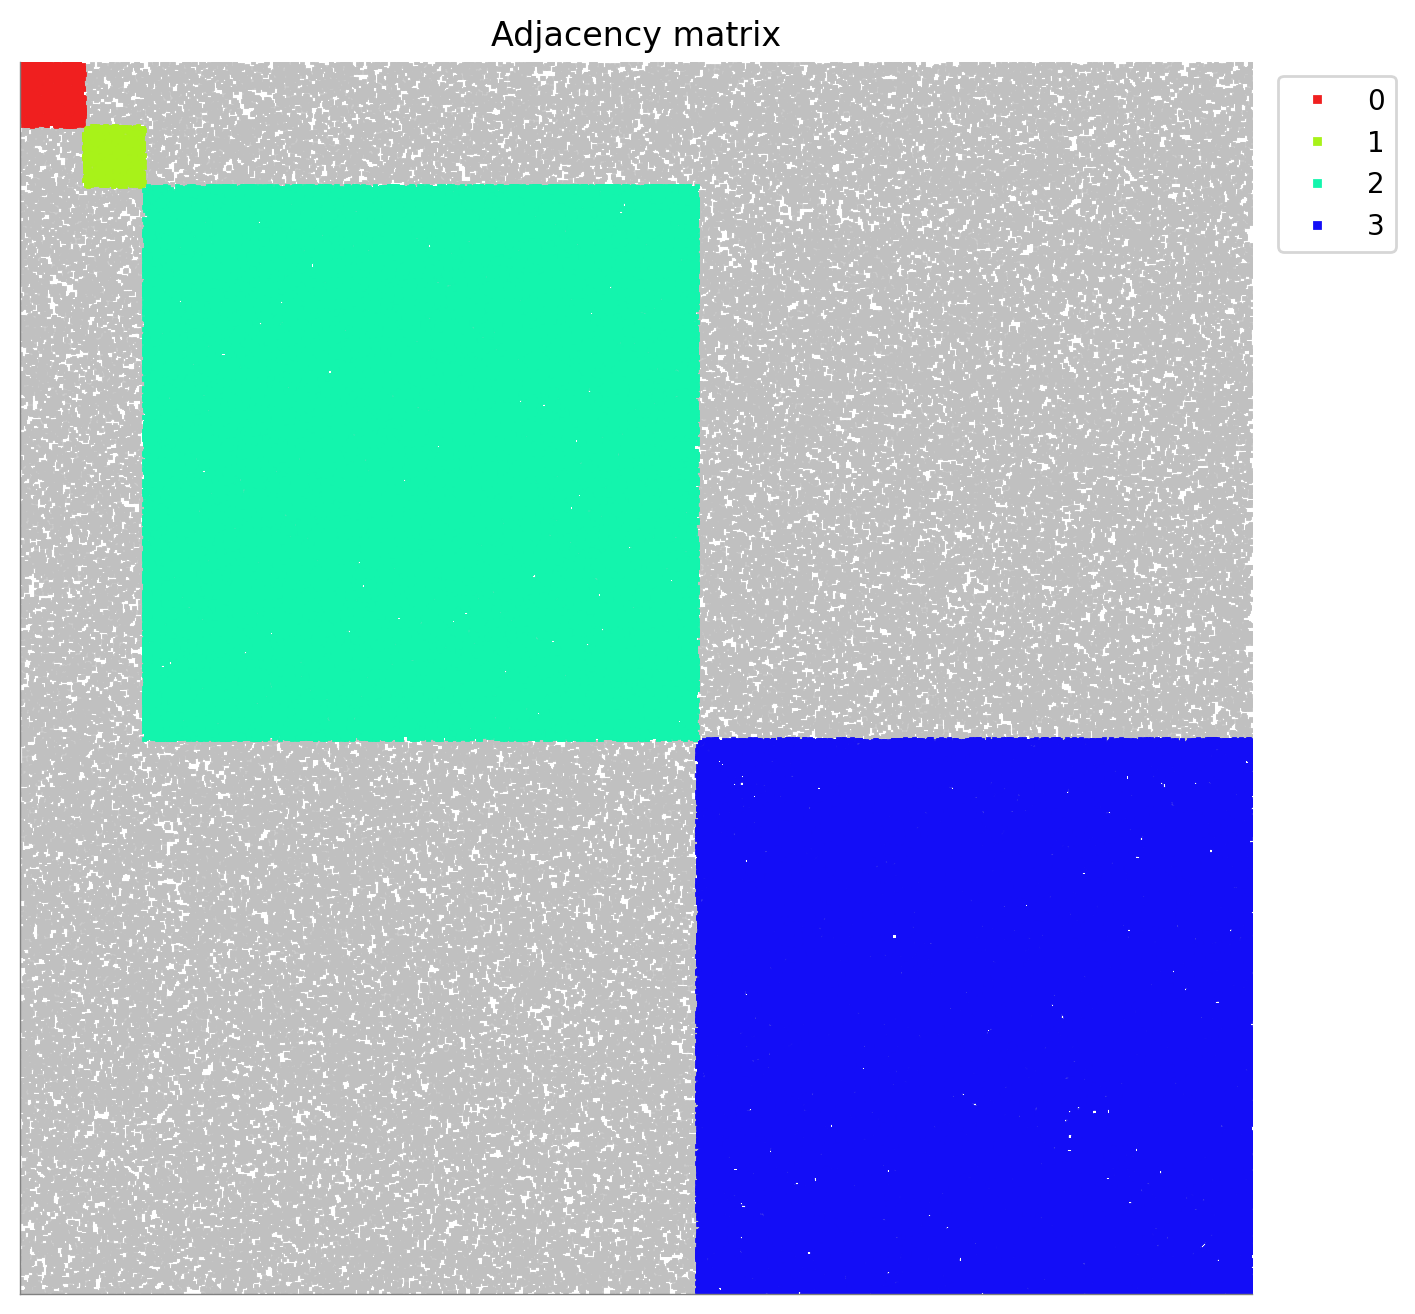

In [7]:
_, sizes = np.unique(True_P1, return_counts=True)
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(colors_red[0], colors_blue[0], np.size(np.unique(True_P1)))
plot_block_matrix(A1.toarray(), partition_names=list(range(len(sizes))), partition_counts=sizes, colors=c)

Metadata generation done!
number of groups = 4, Kpos=4, Kneg=0
True Sub Group Number is 4
BH Sub Group Number is 4


findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: verdana
findfont: Generic family 'sans-serif'

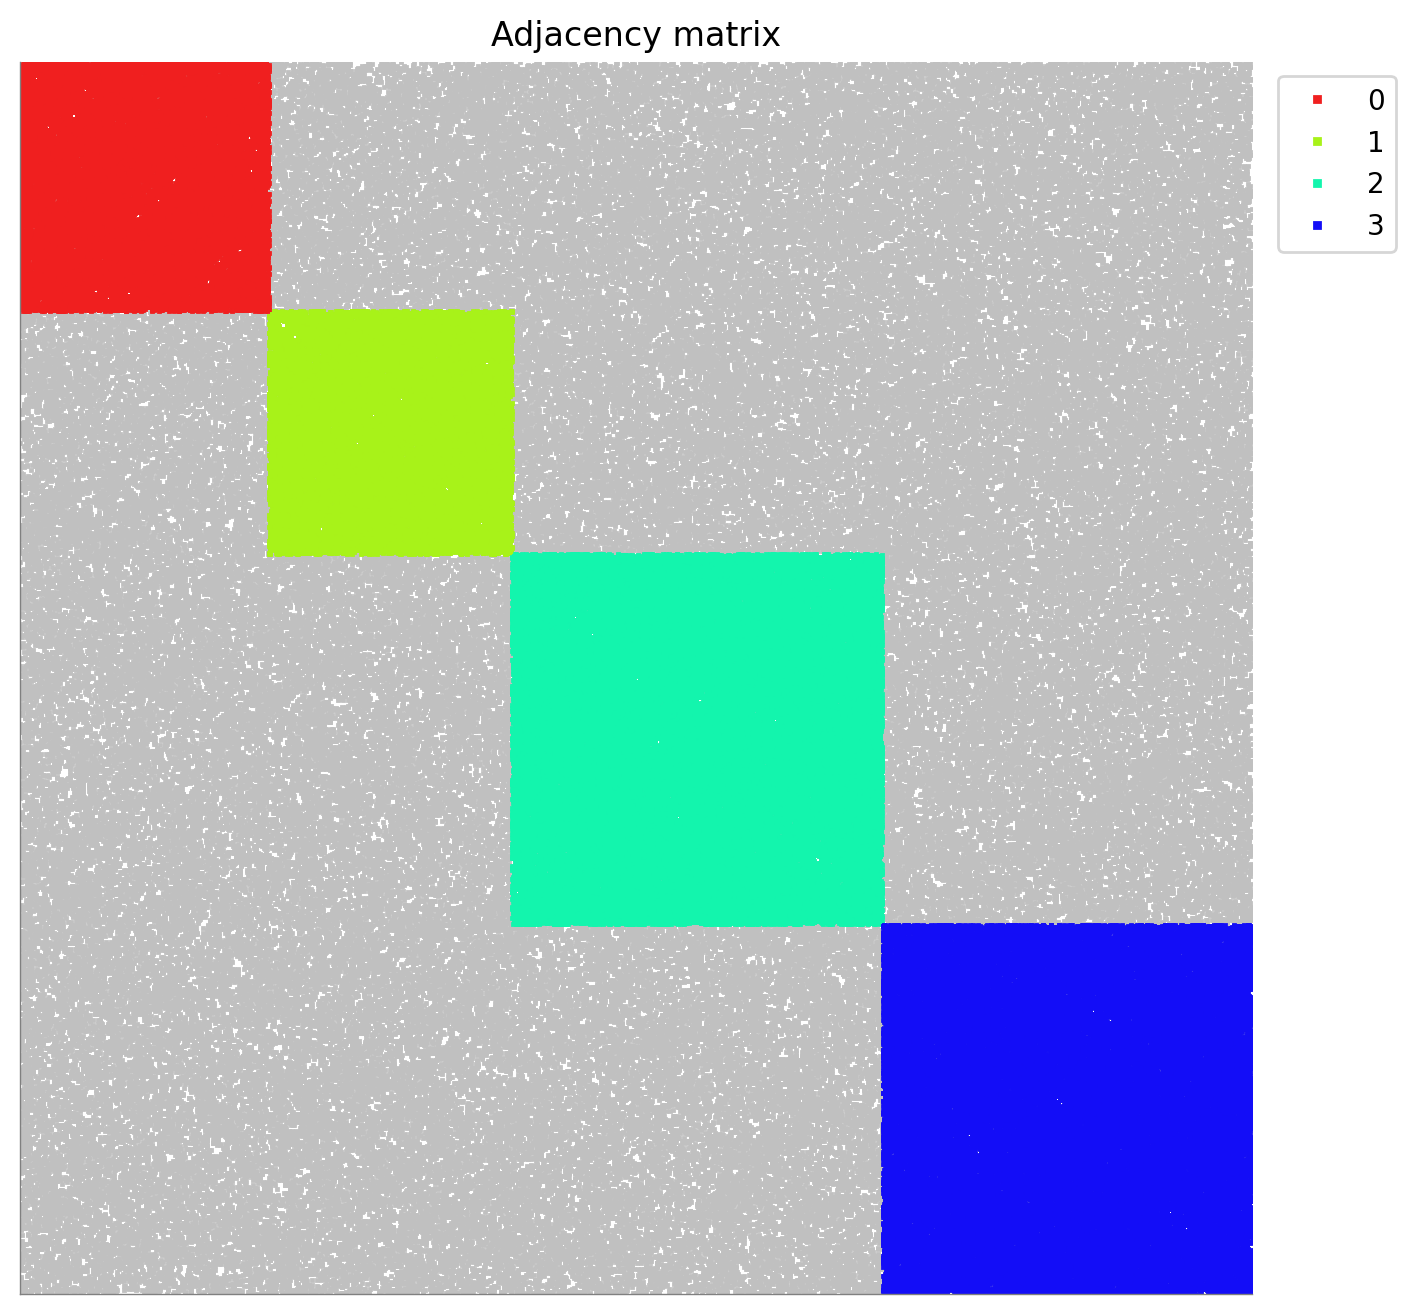

In [9]:
delta=0.01
rho=0.4
A2, True_P2, BH_P2, BH_N2 = cd_for_network(delta=delta, rho=rho, n=n, d=d, Z_s=Z_s, Z_b=Z_b)
_, sizes = np.unique(True_P2, return_counts=True)
fig = plt.figure(figsize=(8, 8))
widths = [4]
heights = [4]
spec5 = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights)
row = 0
col = 0
ax = fig.add_subplot(spec5[row, col])
c = gen_colors(colors_red[0], colors_blue[0], np.size(np.unique(True_P2)))
plot_block_matrix(A2.toarray(), partition_names=list(range(len(sizes))), partition_counts=sizes, colors=c)